# Noiseless VQE Simulation of Lithium Hydride (LiH)

This notebook implements the **Variational Quantum Eigensolver (VQE)** algorithm to estimate the **ground state energy of lithium hydride (LiH)** using PennyLane’s quantum chemistry module. The simulation is performed on a **noiseless quantum device**, focusing exclusively on **double excitations** within a Unitary Coupled Cluster (UCC) ansatz.

### Key Features:
- **Molecular Hamiltonian Generation**: Constructs the LiH Hamiltonian using the STO-3G basis and maps it to a qubit representation.
- **Reference State**: Prepares the Hartree-Fock (HF) state from the mean-field solution.
- **Ansatz Construction**: Applies a double excitation ansatz derived from the UCCSD method.
- **VQE Optimization**: Minimizes the expectation value of the Hamiltonian using **Gradient Descent**.
- **Results Analysis**:
  - Convergence plot of energy vs. iteration.
  - Visualization of the ground state quantum amplitudes.

### Purpose:
To benchmark and analyze the noiseless behavior of VQE on LiH as a testbed for quantum chemistry applications. This forms a foundation for:
- Testing optimizers,
- Comparing excitation strategies,

In [1]:
import pennylane as qml                  # Quantum circuit builder and device management
from pennylane import numpy as np        # Not regular NumPy, but similar and supports automatic differentiation
from pennylane import qchem              # Quantum chemistry module used to define molecule Hamiltonians
from pennylane.qchem import excitations  # Single and double excitations used in the UCCSD (Unitary Coupled Cluster Singles and Doubles) ansatz
import matplotlib.pyplot as plt
import os
from vqe_utils import excitation_ansatz, get_optimizer, set_seed  # helpers

set_seed(0)                              # Reproducible runs
IMG_DIR = "images"                       # Single image directory used repo-wide
os.makedirs(IMG_DIR, exist_ok=True)

In [2]:
# Define the atoms in the LiH molecule
symbols = ["Li", "H"]

# Define the coordinates (in Ångströms)
coordinates = np.array([
    [0.0, 0.0, 0.0],  # Lithium atom at the origin
    [0.0, 0.0, 1.6]   # Hydrogen atom positioned 1.6 Å along the z-axis
])

In [3]:
# Define the LiH Hamiltonian and the number of qubits required
# Default STO-3G basis set
hamiltonian, qubits = qchem.molecular_hamiltonian(symbols, coordinates, charge=0)

# 1 spatial orbital for H and 5 for Li
# Each spatial orbital is doubly-degenerate (2 spin orbitals)
print(f"{qubits} qubits required")

12 qubits required


In [4]:
# Which orbitals are occupied (1) or unoccupied (0) in the mean-field (Hartree-Fock) solution
electrons = 4  # 1 from H and 3 from Li
hf = qchem.hf_state(electrons=electrons, orbitals=qubits)  # Creates the Hartree-Fock state

# Show that the first 4 orbitals are occupied
# Print the state in bra-ket notation (leftmost bit = highest-index spin orbital)
print(f"Hartree-Fock state: {'|' + ''.join(str(bit) for bit in hf) + '⟩'}")

Hartree-Fock state: |111100000000⟩


In [5]:
# Define the number of required quantum wires / logical qubits
num_wires = qubits

# Create quantum device simulator backend
dev = qml.device("default.qubit",  # Noiseless state vector simulator
                 wires=num_wires)


@qml.qnode(dev)  # Transforms exp_energy below into a quantum node
def exp_energy(state):
    qml.BasisState(np.array(state), wires=range(num_wires))

    # Return the expectation value of the molecular Hamiltonian
    return qml.expval(hamiltonian)

# Calculate ⟨ψ_hf| hamiltonian |ψ_hf⟩ in Hartree (Ha) units
# 1 Ha = 27.2 eV
exp_energy(hf)

tensor(-7.66194677, requires_grad=True)

In [6]:
# Generate excitation indices
singles, doubles = excitations(electrons=electrons, orbitals=qubits)
print(f"Singles Excitations: {singles}")  # e.g: [0, 4] is a single excitation of an electron in orbital 0 to orbital 4
print(f"Doubles Excitations: {doubles}")  # e.g: [0, 1, 4, 5] is a double excitation of electrons in orbitals 0 and 1 to orbitals 4 and 5


# Define an ansatz using the excitations
def ansatz(params):
    # Initialize the qubit register in the Hartree-Fock state
    qml.BasisState(hf, wires=range(num_wires))

    # We only loop over the double excitations for LiH
    for i, excitation in enumerate(doubles):
        # Unitary quantum gate representing a double excitation
        qml.DoubleExcitation(params[i], wires=excitation)

Singles Excitations: [[0, 4], [0, 6], [0, 8], [0, 10], [1, 5], [1, 7], [1, 9], [1, 11], [2, 4], [2, 6], [2, 8], [2, 10], [3, 5], [3, 7], [3, 9], [3, 11]]
Doubles Excitations: [[0, 1, 4, 5], [0, 1, 4, 7], [0, 1, 4, 9], [0, 1, 4, 11], [0, 1, 5, 6], [0, 1, 5, 8], [0, 1, 5, 10], [0, 1, 6, 7], [0, 1, 6, 9], [0, 1, 6, 11], [0, 1, 7, 8], [0, 1, 7, 10], [0, 1, 8, 9], [0, 1, 8, 11], [0, 1, 9, 10], [0, 1, 10, 11], [0, 2, 4, 6], [0, 2, 4, 8], [0, 2, 4, 10], [0, 2, 6, 8], [0, 2, 6, 10], [0, 2, 8, 10], [0, 3, 4, 5], [0, 3, 4, 7], [0, 3, 4, 9], [0, 3, 4, 11], [0, 3, 5, 6], [0, 3, 5, 8], [0, 3, 5, 10], [0, 3, 6, 7], [0, 3, 6, 9], [0, 3, 6, 11], [0, 3, 7, 8], [0, 3, 7, 10], [0, 3, 8, 9], [0, 3, 8, 11], [0, 3, 9, 10], [0, 3, 10, 11], [1, 2, 4, 5], [1, 2, 4, 7], [1, 2, 4, 9], [1, 2, 4, 11], [1, 2, 5, 6], [1, 2, 5, 8], [1, 2, 5, 10], [1, 2, 6, 7], [1, 2, 6, 9], [1, 2, 6, 11], [1, 2, 7, 8], [1, 2, 7, 10], [1, 2, 8, 9], [1, 2, 8, 11], [1, 2, 9, 10], [1, 2, 10, 11], [1, 3, 5, 7], [1, 3, 5, 9], [1, 3, 5, 11]

In [7]:
# Define the VQE cost function
@qml.qnode(dev)
def cost_function(params):
    excitation_ansatz(params, wires=range(num_wires), hf_state=hf, excitations=doubles, excitation_type="double")

    # Measure the expectation value of the Hamiltonian after applying the ansatz:
    # E(theta) = ⟨ψ(theta)| H |ψ(theta)⟩
    return qml.expval(hamiltonian)

# Create a vector of zeros with the same length as the number of double excitations
initial_params = np.zeros(len(doubles), requires_grad=True)

# Confirm the initial energy of the system using the Hartree-Fock state
# This is the starting point for classical optimization
cost_function(initial_params)

tensor(-7.66194677, requires_grad=True)

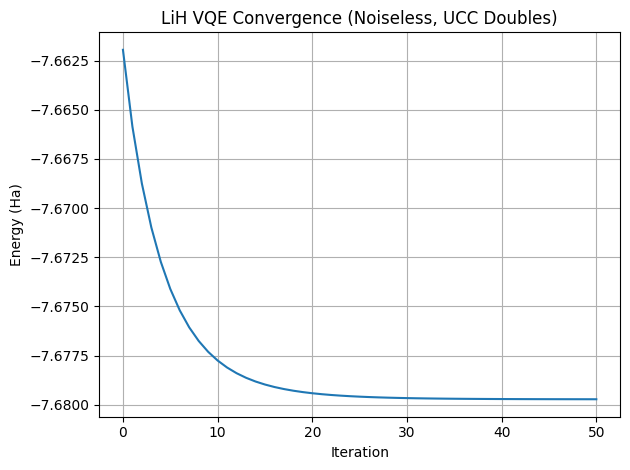

In [8]:
# The optimizer uses automatic differentiation to compute gradients and adjust the parameters
opt = get_optimizer("GradientDescent", stepsize=0.2)  # Initializes the gradient descent optimizer
theta = np.zeros(len(doubles), requires_grad=True)    # Initializes a vector of zeros as the starting parameters for the ansatz

# Initialize energy tracking list
energy = [cost_function(theta)]

# VQE optimization loop
max_iterations = 50
for _ in range(max_iterations):
    # Updates parameters theta to minimize the cost function (energy)
    theta, prev_energy = opt.step_and_cost(cost_function, theta)
    energy.append(cost_function(theta))

# Plotting VQE convergence
plt.plot(range(len(energy)), energy)
plt.xlabel('Iteration')
plt.ylabel('Energy (Ha)')
plt.title('LiH VQE Convergence (Noiseless, UCC Doubles)')
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{IMG_DIR}/LiH_Gradient_Descent.png', dpi=300)
plt.show()

In [9]:
print(f"Final ground state energy: {energy[-1]:.8f} Ha")

# Optimized angles in the DoubleExcitation gates for first two excitations
print(f"Final parameters: {theta[0]:.8f}, {theta[1]:.8f}")

Final ground state energy: -7.67972341 Ha
Final parameters: 0.00624935, 0.00000000


In [10]:
@qml.qnode(dev)
def ground_state(params):
    ansatz(params)

    # Return the entire quantum statevector
    return qml.state()

# Run the circuit using the final optimized angles
final_state = ground_state(theta)

# Find non-zero (or near non-zero) entries
threshold = 1e-2  # Recommended smaller threshold to capture all significant amplitudes
non_zero_indices = np.where(np.abs(final_state) > threshold)[0]
non_zero_amplitudes = final_state[non_zero_indices]

# Build the full ket notation string
ket_terms = []
for idx, amp in zip(non_zero_indices, non_zero_amplitudes):
    binary_state = f"|{idx:0{num_wires}b}⟩"
    amp_str = f"{amp.real:.4f}" if np.isclose(amp.imag, 0, atol=1e-6) else f"({amp.real:.4f} + {amp.imag:.4f}j)"
    ket_terms.append(f"{amp_str}{binary_state}")

# Join all terms into one quantum state expression and print
ket_notation = " + ".join(ket_terms)
print(f"Ground state of LiH:\n|ψ⟩ = {ket_notation}")

Ground state of LiH:
|ψ⟩ = -0.1010|110000000011⟩ + -0.0393|110000001100⟩ + -0.0393|110000110000⟩ + -0.0365|110001000010⟩ + 0.0365|110010000001⟩ + -0.0155|110011000000⟩ + 0.9918|111100000000⟩


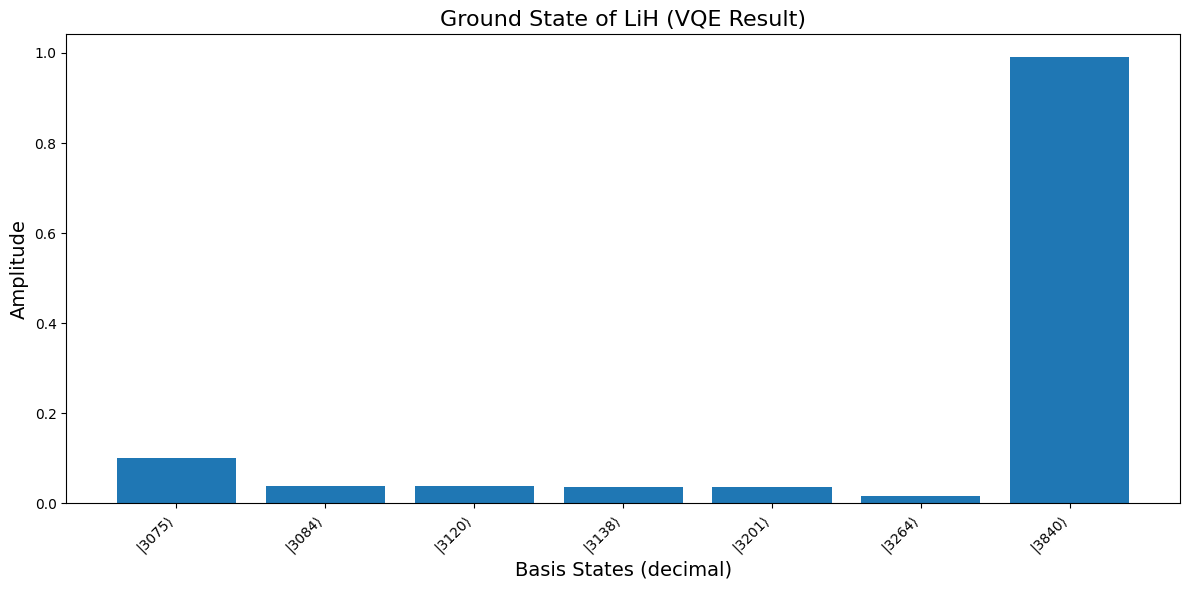

In [11]:
# Prepare labels and amplitudes for the plot
labels = [f"|{i}⟩" for i in non_zero_indices]  # decimal labels
amplitudes = np.abs(non_zero_amplitudes)

plt.figure(figsize=(12, 6))
plt.bar(labels, amplitudes)
plt.xlabel('Basis States (decimal)', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.title('Ground State of LiH (VQE Result)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(f'{IMG_DIR}/LiH_Ground_State.png', dpi=300)
plt.show()